In [1]:
%matplotlib inline

import numpy as np
import math

from numpy.fft import fftshift, fft2
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from skimage.io import imshow, imread, imsave
from skimage.util import img_as_float, img_as_ubyte
from typing import List

Гауссовская пирамида:

In [2]:
def get_gauss(sigma: float=1.):
    diam = round(sigma * 3) * 2 + 1
    rad = diam // 2
    kernel = np.ndarray(shape=(diam, diam), dtype=np.float64)
    for x in range(-rad, rad + 1):
        for y in range(-rad, rad +1):
            gauss_value = (1 / (2 * math.pi * sigma ** 2)) * math.pow(math.e, ((-x ** 2 - y ** 2) / (2 * sigma ** 2)))
            kernel[x + rad, y + rad] = gauss_value
    S = sum(sum(kernel))
    kernel = kernel / S
    return kernel

In [3]:
def build_gauss_pyramid(img, sigma: float=1., n_layers: int=5) -> List:
    pyramid = []
    kernel = get_gauss(sigma)
    current_img = img
    for _ in range(n_layers):
        gaussian_img = convolve2d(current_img, kernel, mode='same', boundary='symm')
        pyramid.append(gaussian_img)
        current_img = gaussian_img
    return pyramid


In [4]:
def show_freq(img):
    img = rgb2gray(img)
    freq = np.log(1 + abs(fftshift(fft2(img))))
    imshow(freq, cmap='gray')

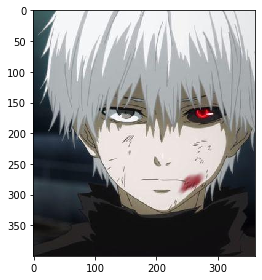

In [5]:
img = imread('kaneki.jpg')
imshow(img)

Так как изображение цветное, построим гауссовскую пирамиду для каждого канала отдельно:

In [6]:
sigma = 1
n_layers = 5
img = img_as_float(img)
r = img[:, :, 0]
g = img[:, :, 1]
b = img[:, :, 2]
pyramid_r = build_gauss_pyramid(r, sigma=sigma, n_layers=n_layers)
pyramid_g = build_gauss_pyramid(g, sigma=sigma, n_layers=n_layers)
pyramid_b = build_gauss_pyramid(b, sigma=sigma, n_layers=n_layers)
rgb_gauss_pyramid = []
for i in range(n_layers):
    rgb_img = np.dstack((pyramid_r[i], pyramid_g[i], pyramid_b[i]))
    rgb_gauss_pyramid.append(rgb_img)

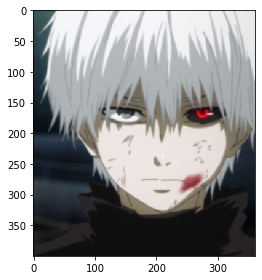

In [7]:
imshow(rgb_gauss_pyramid[0])

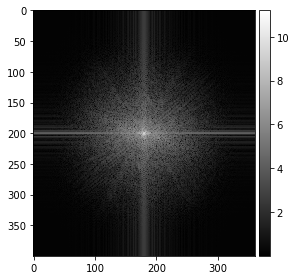

In [8]:
show_freq(rgb_gauss_pyramid[0])

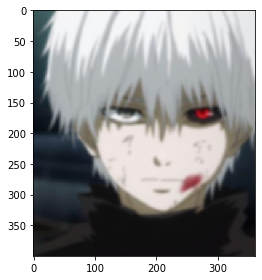

In [9]:
imshow(rgb_gauss_pyramid[4])

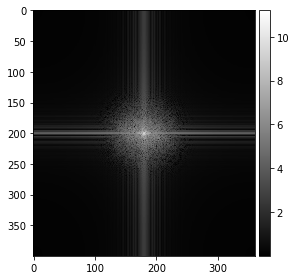

In [10]:
show_freq(rgb_gauss_pyramid[4])

Лапласовская пирамида:

In [11]:
def build_laplace_pyramid(img, sigma: float=1., n_layers: int=5) -> List:
    gauss_pyramid = build_gauss_pyramid(img, sigma=sigma, n_layers=n_layers)
    current_img = img
    pyramid = []
    for i in range(n_layers):
        laplace_img = current_img - gauss_pyramid[i]
        pyramid.append(laplace_img)
        current_img = gauss_pyramid[i]
    pyramid.append(current_img)
    return pyramid

In [12]:
img = rgb2gray(img)
laplace_pyramid = build_laplace_pyramid(img, sigma=sigma, n_layers=n_layers)

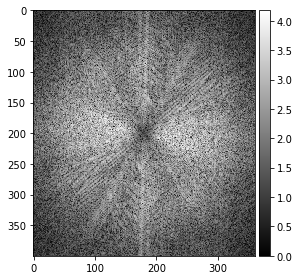

In [13]:
show_freq(laplace_pyramid[0])

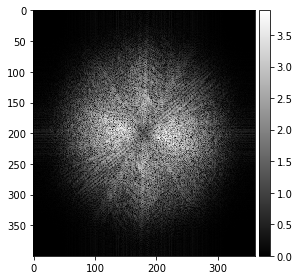

In [14]:
show_freq(laplace_pyramid[1])

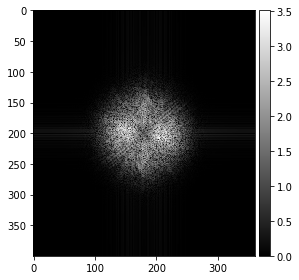

In [15]:
show_freq(laplace_pyramid[4])

Проверим, что лаплассовская пирамида построена правильно:

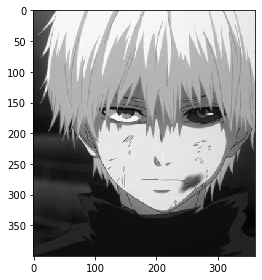

In [16]:
imshow(img)

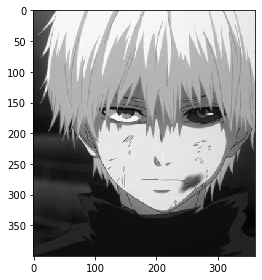

In [17]:
restored_img = sum(laplace_pyramid)
imshow(restored_img)

Склейка:

In [18]:
def blend(img1, img2, mask, sigma=1., n_layers=5):
    L1 = build_laplace_pyramid(img1, sigma=sigma, n_layers=n_layers-1)
    L2 = build_laplace_pyramid(img2, sigma=sigma, n_layers=n_layers-1)
    GM = build_gauss_pyramid(mask, sigma=sigma, n_layers=n_layers)
    blended_pyramid = []
    for i in range(n_layers):
        LS = GM[i] * L1[i] + (1 - GM[i]) * L2[i]
        blended_pyramid.append(LS)
    return blended_pyramid

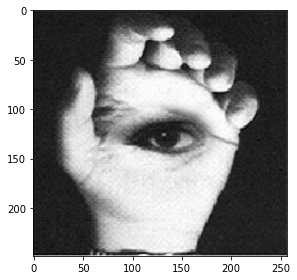

In [19]:
sigma = 2
n_layers = 6
img1 = imread('a.png')
img1 = rgb2gray(img1)
img2 = imread('b.png')
img2 = rgb2gray(img2)
mask = imread('mask.png')
mask = rgb2gray(mask)
mask = (mask > 0.5).astype('float')

blended_pyramid = blend(img1, img2, mask, sigma=sigma, n_layers=n_layers)
blended_img = sum(blended_pyramid)
imshow(blended_img)

Склейка по собственным изображениям:

In [20]:
def blend_rgb(img1, img2, mask, sigma=1, n_layers=5):
    blended_channels = []
    for i in range(3):
        img1_i = img1[:, :, i]
        img2_i = img2[:, :, i]
        blended_pyramid_i = blend(img1_i, img2_i, mask, sigma, n_layers)
        blended_img_i = sum(blended_pyramid_i)
        blended_channels.append(blended_img_i)
    blended_rgb_img = np.dstack((blended_channels[0], blended_channels[1], blended_channels[2]))
    blended_rgb_img = np.clip(blended_rgb_img, 0, 1)
    return blended_rgb_img

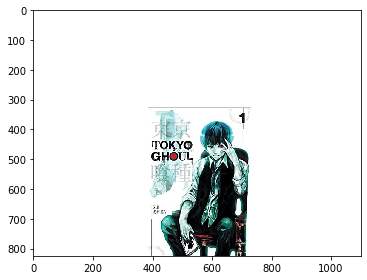

In [21]:
img3 = imread('sitting_kaneki.jpg')
img3 = img_as_float(img3)
imshow(img3)

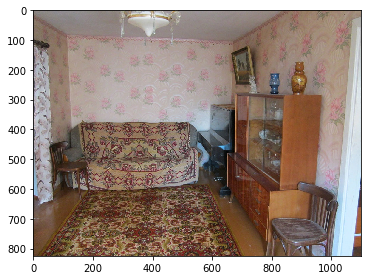

In [22]:
img4 = imread('sovet_flat.jpg')
img4 = img_as_float(img4)
imshow(img4)

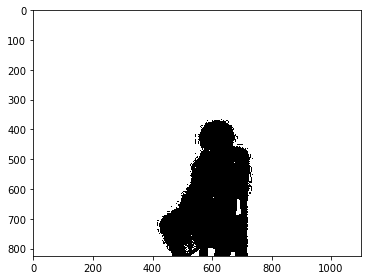

In [23]:
mask2 = imread('mask1.png')
mask2 = rgb2gray(mask2)
for i in range(mask2.shape[0]):
    for j in range(mask2.shape[1]):
        if mask2[i, j] != 1.0:
            mask2[i, j] = 0
imshow(mask2)

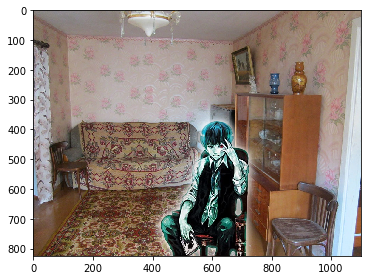

In [24]:
sigma = 6
n_layers = 6 

res1 = blend_rgb(img4, img3, mask2, sigma=sigma, n_layers=n_layers)
imshow(res1)
res1 = img_as_ubyte(res1)
imsave('res1.png', res1)

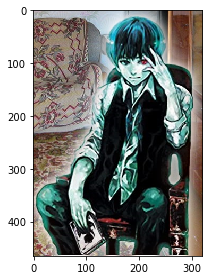

In [35]:
res1_resized = imread('res1_resized.png')
imshow(res1_resized)

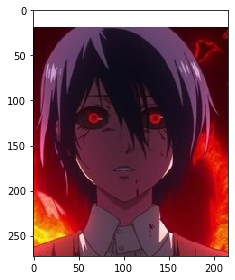

In [26]:
img5 = imread('Touka.jpg')
img5 = img_as_float(img5)
imshow(img5)

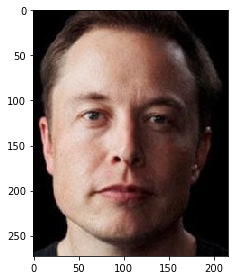

In [27]:
img6 = imread('Elon_Musk.jpg')
img6 = img_as_float(img6)
imshow(img6)

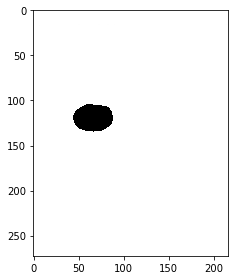

In [28]:
mask3 = imread('mask3.png')
mask3 = rgb2gray(mask3)
imshow(mask3)

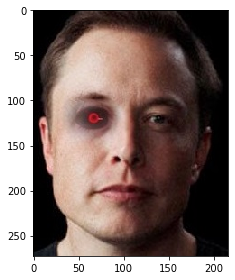

In [29]:
sigma = 4
n_layers = 6 

res2 = blend_rgb(img6, img5, mask3, sigma=sigma, n_layers=n_layers)
imshow(res2)
res2 = img_as_ubyte(res2)
imsave('res2.png', res2)

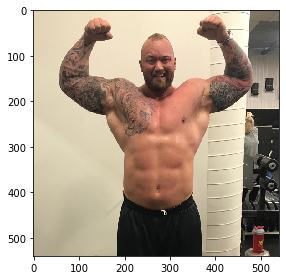

In [30]:
img7 = imread('Bjornsson.jpg')
img7 = img_as_float(img7)
imshow(img7)

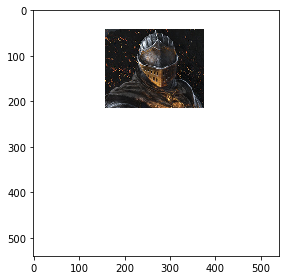

In [31]:
img8 = imread('knight_head.jpg')
img8 = img_as_float(img8)
imshow(img8)

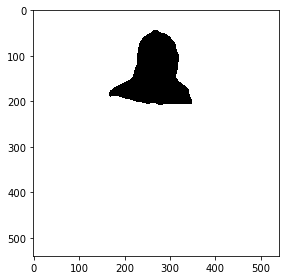

In [32]:
mask4 = imread('mask4.jpg')
mask4 = rgb2gray(mask4)
for i in range(mask4.shape[0]):
    for j in range(mask4.shape[1]):
        if mask4[i, j] != 1.0:
            mask4[i, j] = 0
imshow(mask4)

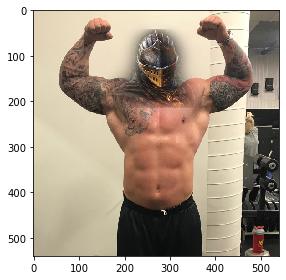

In [33]:
sigma = 8
n_layers = 5

res3 = blend_rgb(img7, img8, mask4, sigma=sigma, n_layers=n_layers)
imshow(res3)
res3 = img_as_ubyte(res3)
imsave('res3.png', res3)

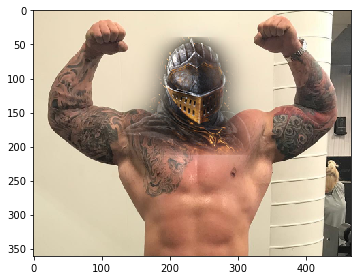

In [34]:
res3_resized = imread('res3_resized.png')
imshow(res3_resized)